In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sympy import *
from sympy.plotting import plot

import torch
from torchvision import models
from torchvision.io import read_image
from torchvision.transforms import Resize, Normalize, CenterCrop, ToTensor
from glob import glob
import json

# Prevent warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#### Q6
Consider the simple function R($\beta$) = sin($\beta$) + $\beta$/10.

(a) Draw a graph of this function over the range $\beta$ ∈ [−6, 6].

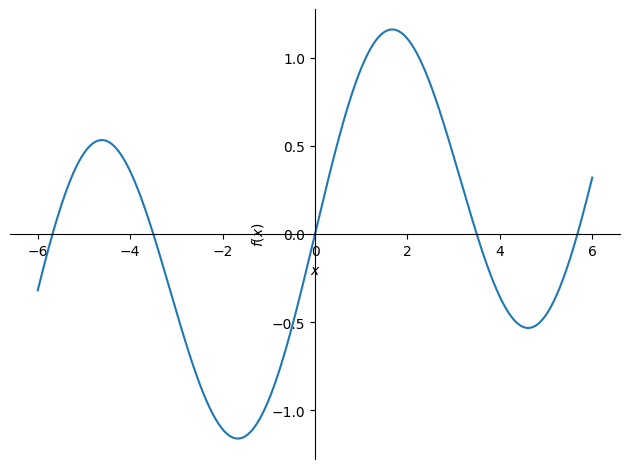

In [2]:
x = Symbol('x')
f1 = sin(x) + x/10
plot(f1, (x,-6,6));

(b) What is the derivative of this function?


In [3]:
print(f'The deivative of this function is {f1.diff(x)}')

The deivative of this function is cos(x) + 1/10


(c) Given $\beta_{0}$ = 2.3, run gradient descent to find a local minimum
of R($\beta$) using a learning rate of $\rho$ = 0.1. Show each of $\beta_{0}$ , $\beta_{1}$ , . . . in your plot, as well as the final answer.

In [4]:
def gradient_descent(initial, rate, f):
  results = pd.DataFrame(columns=['x', 'f'])
  first_row = pd.DataFrame({'x': [initial], 'f': [f.subs(x,initial)]})
  results = pd.concat([results, first_row], ignore_index=True)
  gradient = f.diff(x)
  beta = initial
  for i in range(10000):
    beta_new = beta - rate*gradient.subs(x,beta)
    new_row = pd.DataFrame({'x': [beta_new], 'f': [f.subs(x,beta_new)]})
    results = pd.concat([results, new_row], ignore_index=True)
    if f.subs(x,beta_new) < f.subs(x,beta):
      beta = beta_new
    else:
      break
  return results, beta_new

results1, minima1 = gradient_descent(2.3, 0.1, f1)
print(f"The minima occurs at x={minima1}")

The minima occurs at x=4.61222153638557


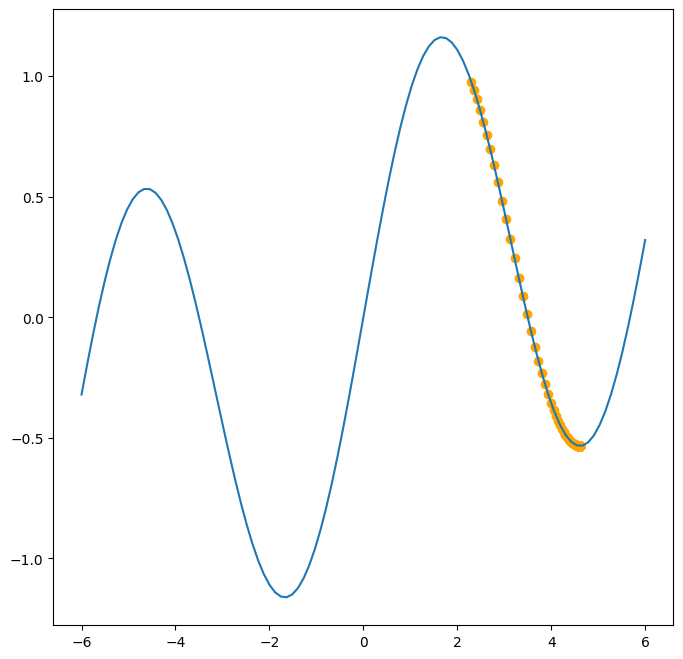

In [5]:
X = np.linspace(-6,6,100)
f = np.sin(X) + X/10
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(X,f);
ax.scatter(results1['x'],results1['f'], color='orange');

(d) Repeat with $\beta_{0}$ = 1.4

In [6]:
results2, minima2 = gradient_descent(1.4, 0.1, f1)
print(f"The minima occurs at x={minima2}")

The minima occurs at x=-1.67096371106808


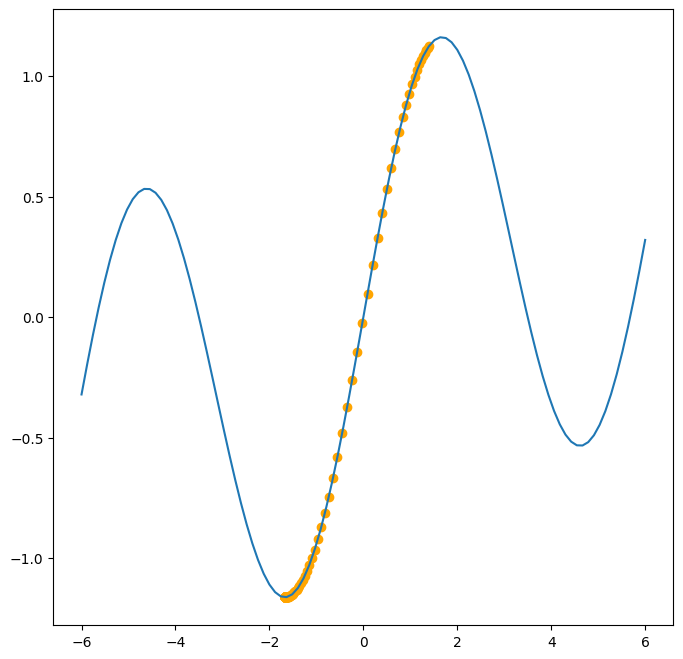

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(X,f);
ax.scatter(results2['x'],results2['f'], color='orange');

#### Q8

From your collection of personal photographs, pick 10 images of animals(such as dogs, cats, birds, farm animals, etc.). If the subject does not occupy a reasonable part of the image, then crop the image. Now use a pretrained image classification CNN as in Lab 10.9.4 to predict the class of each of your images, and report the probabilities for the top five predicted classes for each image.

In [8]:
# Read images and preprocess
resize = Resize((232,232), antialias=True)
crop = CenterCrop(224)
normalize = Normalize([0.485,0.456,0.406],
                      [0.229,0.224,0.225])

imgfiles = sorted([f for f in glob('Animals/*')])
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255) for f in imgfiles])
imgs = normalize(imgs)
imgs.size()

torch.Size([10, 3, 224, 224])

In [9]:
resnet_model = models.resnet50(pretrained=True) # Define the model
resnet_model.eval() # Ensure the model is ready to predict on new data

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
# Predict labels for our images
img_preds = resnet_model(imgs)

# Compute image probabilites by applying softmax
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:,None]

# Download index file associated with imagenet to see class labels
labs = json.load(open('imagenet_class_index.json'))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in  labs.items()], columns=['idx', 'label'])
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()

In [11]:
# Return a dataframe with top 5 probability estimates for each image file
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:5]
    print(f'Image: {imgfile}')
    print(img_df.reset_index().drop(columns=['idx']))

Image: Animals/Asiatic Bear.jpg
                 label      prob
0  American_black_bear  0.553854
1           sloth_bear  0.433449
2           brown_bear  0.012239
3            wild_boar  0.000128
4               wombat  0.000110
Image: Animals/Asiatic Lion.jpg
     label      prob
0     lion  0.996737
1  macaque  0.002108
2   cougar  0.000805
3    tiger  0.000052
4    dingo  0.000041
Image: Animals/Chimpanzee.jpg
           label      prob
0     chimpanzee  0.962561
1        siamang  0.019798
2  spider_monkey  0.003776
3        macaque  0.003719
4       capuchin  0.002746
Image: Animals/Great White Pelican.jpg
         label      prob
0      pelican  0.993594
1    spoonbill  0.004373
2     flamingo  0.000893
3  black_stork  0.000398
4  white_stork  0.000303
Image: Animals/Guar.jpg
           label      prob
0  water_buffalo  0.826592
1             ox  0.168166
2         oxcart  0.002819
3          bison  0.002175
4           plow  0.000186
Image: Animals/Leopard.jpg
          label   